In [1]:
import glob
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t

from scipy.optimize import curve_fit


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from astropy.modeling import models, fitting
from scipy import special

from fink_utils.sso import spins as finkus

In [2]:
# G12 line in G1G2 space
def G12_to_G1G2(g12):

    G1_a, G2_a = 0.0, 0.53513350
    G1_b, G2_b = 0.84293649, -0.53513350

    G1 = G1_a + g12 * G1_b
    G2 = G2_a + g12 * G2_b

    return G1, G2

# Simple 1D Gaussian
def gauss(x, m, mu, sigma):
    return m * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Two 1D Gaussians
def double_gauss(x, m1, mu1, sigma1, m2, mu2, sigma2):
    g1 = gauss(x, m1, mu1, sigma1)
    g2 = gauss(x, m2, mu2, sigma2)
    return g1 + g2

# Get ZTF fit

In [3]:
# Local Configuration
bft_file = '/data/ssodnet/ssoBFT-latest.parquet'
data_fink = '/data/fink/tutorials/sso/spins/'
data_fink = './'


In [4]:
# ZTF filters
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])


mag_to_V ={
        1: -0.2833,  # ZTF g
        2: 0.1777,   # ZTF r
        3: 0.4388,   # ATLAS orange
        4: -0.0986   # ATLAS cyan
    }

fink_colors = ['#15284F', '#F5622E']


In [5]:
data = pd.read_parquet(f'{data_fink}data/sso_ZTF.parquet')

In [6]:
data

,ssnamenr,nmeasurements,ndays,params,number,name,HG_H_g,HG_dH_g,HG_G_g,HG_dG_g,...,HG1G2hyb_dDEC0,HG1G2hyb_R,HG1G2hyb_dR,HG1G2hyb_rms,HG1G2hyb_chi2red,HG1G2hyb_status,HG1G2hyb_fit,HG1G2hyb_minCosLambda,HG1G2hyb_meanCosLambda,HG1G2hyb_maxCosLambda
0,95367,82,1037.766238,"{'G_1': 0.06303630024194717, 'G_2': 0.19601918...",95367,2002 CS157,15.205434,0.049852,6.303630e-02,0.065679,...,158.532502,0.922042,0.115025,0.077086,0.497046,2.0,0.0,1.012016e-06,0.139533,0.927224
1,250264,64,219.697303,"{'G_1': 0.22324514389038086, 'G_2': 0.31732639...",250264,2003 CV12,16.374287,0.171846,2.232451e-01,0.148994,...,2.862553,0.100000,0.053895,0.159935,4.771893,2.0,0.0,9.388329e-01,0.988473,0.995369
2,26487,208,1101.873183,"{'G_1': 0.33757442235946655, 'G_2': 0.33143043...",26487,2000 AV236,14.556883,0.039258,3.375744e-01,0.040907,...,36.886276,0.825462,0.183103,0.104603,5.488952,2.0,0.0,1.837519e-06,0.257722,0.568765
3,189809,63,1002.917616,"{'G_1': 2.0782619075841241e-16, 'G_2': 0.08747...",189809,2002 LO19,15.083442,0.085618,2.078262e-16,0.089987,...,12.368218,0.236502,0.116943,0.146654,2.808556,2.0,0.0,6.508819e-01,0.705825,0.802373
4,34395,116,1087.781169,"{'G_1': 0.5242671966552734, 'G_2': 0.381103187...",34395,2000 RS73,15.081876,0.147779,5.242672e-01,0.206629,...,14.341654,0.532330,0.467085,0.254345,9.497408,2.0,0.0,5.012663e-03,0.161519,0.300628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115142,20866,216,1061.878310,"{'G_1': 0.25884151458740234, 'G_2': 0.40618246...",20866,2000 VP37,13.469830,0.094156,2.588415e-01,0.089800,...,18.679753,0.746724,0.027362,0.125369,4.812122,2.0,0.0,2.118916e-03,0.547583,0.936407
115143,39790,96,1016.752407,"{'G_1': 0.08864176273345947, 'G_2': 0.03623726...",39790,1997 PF,13.892776,0.040307,8.864176e-02,0.039136,...,10.597246,0.128320,0.231076,0.071692,1.223396,2.0,0.0,3.269790e-01,0.430643,0.561184
115144,99263,65,794.646273,"{'G_1': 1.0, 'G_2': 0.8298622369766235, 'H_1':...",99263,2001 OZ31,17.481823,0.220211,1.000000e+00,0.380656,...,12.426569,0.436599,0.355626,0.267769,12.144855,2.0,0.0,7.321041e-01,0.885299,0.946877
115145,18754,228,1181.814294,"{'G_1': 0.19368864595890045, 'G_2': 0.32351323...",18754,1999 GL21,14.145675,0.052304,1.936886e-01,0.048243,...,25.098514,0.845688,0.274284,0.159227,9.858122,2.0,0.0,2.312535e-07,0.106539,0.307556


In [7]:
bft = pd.read_parquet(bft_file)

cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3.RA0.value', 'spins.3.DEC0.value',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ] 

data = data.merge( bft[cols], left_on='name', right_on='sso_name', how='left' )


In [8]:
len(data)

115147

# Compare results

In [9]:
data.HG1G2hyb_status.value_counts()

 2.0    96527
 4.0     9631
 3.0     7405
 0.0     1329
-2.0      238
 1.0       17
Name: HG1G2hyb_status, dtype: int64

In [10]:
thres = 1e-3


# HG1G2 parameters
maskG1G2_g = (data.HG1G2_G1_g>thres)  & (data.HG1G2_G2_g>thres) & ((1-data.HG1G2_G1_g-data.HG1G2_G2_g)>thres)
maskG1G2_r = (data.HG1G2_G1_r>thres)  & (data.HG1G2_G2_r>thres) & ((1-data.HG1G2_G1_r-data.HG1G2_G2_r)>thres)
maskG1G2_fit = (data.HG1G2_fit==0)  & (data.HG1G2_status>=2)
maskG1G2 = maskG1G2_fit & maskG1G2_g & maskG1G2_r

# Hybrid ZTF
maskG1G2hyb_g = (data.HG1G2hyb_G1_g>thres)  & (data.HG1G2hyb_G2_g>thres) & ((1-data.HG1G2hyb_G1_g-data.HG1G2hyb_G2_g)>thres)
maskG1G2hyb_r = (data.HG1G2hyb_G1_r>thres)  & (data.HG1G2hyb_G2_r>thres) & ((1-data.HG1G2hyb_G1_r-data.HG1G2hyb_G2_r)>thres)
maskG1G2hyb_ZTF = maskG1G2hyb_g & maskG1G2hyb_r
maskG1G2hyb_fit = (data.HG1G2hyb_fit==0)  & (data.HG1G2hyb_status>=2)
maskG1G2hyb = maskG1G2hyb_fit & maskG1G2hyb_ZTF 

# Hybrid ATLAS
# maskG1G2atlas_g = (data_w_atlas.HG1G2hyb_G1_g>thres)  & (data_w_atlas.HG1G2hyb_G2_g>thres) & ((1-data_w_atlas.HG1G2hyb_G1_g-data_w_atlas.HG1G2hyb_G2_g)>thres)
# maskG1G2atlas_r = (data_w_atlas.HG1G2hyb_G1_r>thres)  & (data_w_atlas.HG1G2hyb_G2_r>thres) & ((1-data_w_atlas.HG1G2hyb_G1_r-data_w_atlas.HG1G2hyb_G2_r)>thres)
# maskG1G2atlas_o = (data_w_atlas.HG1G2hyb_G1_o>thres)  & (data_w_atlas.HG1G2hyb_G2_o>thres) & ((1-data_w_atlas.HG1G2hyb_G1_o-data_w_atlas.HG1G2hyb_G2_o)>thres)
# maskG1G2atlas_c = (data_w_atlas.HG1G2hyb_G1_c>thres)  & (data_w_atlas.HG1G2hyb_G2_c>thres) & ((1-data_w_atlas.HG1G2hyb_G1_c-data_w_atlas.HG1G2hyb_G2_c)>thres)
# maskG1G2atlas_ZTF = maskG1G2atlas_g & maskG1G2atlas_r
# maskG1G2atlas_ATLAS = maskG1G2atlas_o & maskG1G2atlas_c
# maskG1G2atlas = maskG1G2atlas_ZTF  & maskG1G2atlas_ATLAS


# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (data.HG1G2hyb_RA0>thres) & ( np.abs(360-data.HG1G2hyb_RA0)>thres )  & \
           ( np.abs(data.HG1G2hyb_RA0-180)>thres) & ( np.abs(data.HG1G2hyb_DEC0)>thres ) 

# Phase coverage
maskPhase = data.minphase<2.5

# Global mask
mask = maskG1G2 & maskG1G2hyb


print(f' All data       : {len(data):6d}  ({100:>6.2f}%)')
print()
print(f'  Mask G1G2 g   : {len(data[maskG1G2_g]):6d}  ({100.*len(data[maskG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask G1G2 r   : {len(data[maskG1G2_r]):6d}  ({100.*len(data[maskG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask G1G2 g+r : {len(data[maskG1G2]):6d}  ({100.*len(data[maskG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask hyb g    : {len(data[maskG1G2hyb_g]):6d}  ({100.*len(data[maskG1G2hyb_g])/len(data):>6.2f}%)')
print(f'  Mask hyb r    : {len(data[maskG1G2hyb_r]):6d}  ({100.*len(data[maskG1G2hyb_r])/len(data):>6.2f}%)')
print(f'  Mask hyb g+r  : {len(data[maskG1G2hyb]):6d}  ({100.*len(data[maskG1G2hyb])/len(data):>6.2f}%)')
print()
# print(f'  Mask hyb o    : {len(data_w_atlas[maskG1G2atlas_o]):6d}  ({100.*len(data_w_atlas[maskG1G2atlas_o])/len(data):>6.2f}%)')
# print(f'  Mask hyb c    : {len(data_w_atlas[maskG1G2atlas_c]):6d}  ({100.*len(data_w_atlas[maskG1G2atlas_c])/len(data):>6.2f}%)')
# print(f'  Mask hyb o+c  : {len(data_w_atlas[maskG1G2atlas_ATLAS]):6d}  ({100.*len(data_w_atlas[maskG1G2atlas_ATLAS])/len(data):>6.2f}%)')
# print()
# print(f'  Mask hyb groc : {len(data_w_atlas[maskG1G2atlas]):6d}  ({100.*len(data_w_atlas[maskG1G2atlas])/len(data):>6.2f}%)')
# print()
print(f'  Mask Spin     : {len(data[maskSpin]):6d}  ({100.*len(data[maskSpin])/len(data):>6.2f}%)')
print()
print(f'  Mask (both)   : {len(data[mask]):6d}  ({100.*len(data[mask])/len(data):>6.2f}%)')
for minphase in [2,3,4,5]:
    maskPhase = data.minphase<minphase
    print(f'  Mask phase {minphase}  : {len(data[maskPhase]):6d}  ({100.*len(data[maskPhase])/len(data):>6.2f}%)')


# len(data), len(data[mask]), len(data[maskG1G2]), len(data[maskG1G2sp]), len(data[maskG1G2hyb_g]), len(data[maskG1G2hyb_r]), len(data[maskG1G2hyb])

 All data       : 115147  (100.00%)

  Mask G1G2 g   :  56815  ( 49.34%)
  Mask G1G2 r   :  62043  ( 53.88%)
  Mask G1G2 g+r :  40727  ( 35.37%)

  Mask hyb g    :  67796  ( 58.88%)
  Mask hyb r    :  72814  ( 63.24%)
  Mask hyb g+r  :  52393  ( 45.50%)

  Mask Spin     : 111977  ( 97.25%)

  Mask (both)   :  34525  ( 29.98%)
  Mask phase 2  :  57515  ( 49.95%)
  Mask phase 3  :  79455  ( 69.00%)
  Mask phase 4  :  93564  ( 81.26%)
  Mask phase 5  : 101933  ( 88.52%)


## Difference in absolute magnitude

In [11]:
data.columns[:80]

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params', 'number', 'name',
       'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g', 'HG_rms_g', 'HG_H_r',
       'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_rms_r', 'minphase', 'maxphase',
       'n_days', 'n_obs', 'HG_rms', 'HG_chi2red', 'HG1G2_H_g', 'HG1G2_dH_g',
       'HG1G2_G1_g', 'HG1G2_dG1_g', 'HG1G2_G2_g', 'HG1G2_dG2_g', 'HG1G2_rms_g',
       'HG1G2_H_r', 'HG1G2_dH_r', 'HG1G2_G1_r', 'HG1G2_dG1_r', 'HG1G2_G2_r',
       'HG1G2_dG2_r', 'HG1G2_rms_r', 'HG1G2_rms', 'HG1G2_chi2red',
       'HG1G2_status', 'HG1G2_fit', 'HG1G2hyb_H_g', 'HG1G2hyb_dH_g',
       'HG1G2hyb_G1_g', 'HG1G2hyb_dG1_g', 'HG1G2hyb_G2_g', 'HG1G2hyb_dG2_g',
       'HG1G2hyb_rms_g', 'HG1G2hyb_H_r', 'HG1G2hyb_dH_r', 'HG1G2hyb_G1_r',
       'HG1G2hyb_dG1_r', 'HG1G2hyb_G2_r', 'HG1G2hyb_dG2_r', 'HG1G2hyb_rms_r',
       'HG1G2hyb_RA0', 'HG1G2hyb_dRA0', 'HG1G2hyb_DEC0', 'HG1G2hyb_dDEC0',
       'HG1G2hyb_R', 'HG1G2hyb_dR', 'HG1G2hyb_rms', 'HG1G2hyb_chi2red',
       'HG1G2hyb_status', 'HG1G2hy

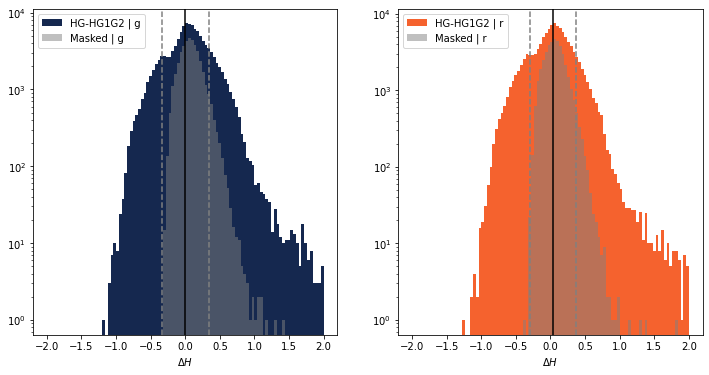

In [12]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']

    hn, hb, _ = ax[i].hist( x, range=r, bins=b, label=f'HG-HG1G2 | {f}', color=fink_colors[i] )
    statarr.append([hb[ np.argmax(hn) ], np.std(x)])

    ax[i].hist( x[maskG1G2], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5 )

    ax[i].axvline( statarr[i][0], color='black' )
    ax[i].axvline( statarr[i][0]-statarr[i][1], color='gray', linestyle='dashed' )
    ax[i].axvline( statarr[i][0]+statarr[i][1], color='gray', linestyle='dashed' )
    
for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')

fig.savefig(f'{data_fink}/gfx_models/deltaH_HG_HG1G2.png', facecolor='white')

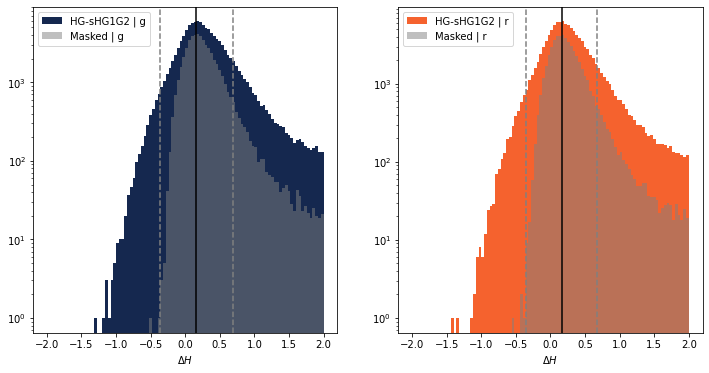

In [13]:
# HG vs HG1G2hyb
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'HG1G2hyb_H_{f}']

    hn, hb, _ = ax[i].hist( x, range=r, bins=b, label=f'HG-sHG1G2 | {f}', color=fink_colors[i] )
    statarr.append([hb[ np.argmax(hn) ], np.std(x)])

    ax[i].hist( x[maskG1G2hyb], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5 )
    
    ax[i].axvline( statarr[i][0], color='black' )
    ax[i].axvline( statarr[i][0]-statarr[i][1], color='gray', linestyle='dashed' )
    ax[i].axvline( statarr[i][0]+statarr[i][1], color='gray', linestyle='dashed' )
    
for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')

fig.savefig(f'{data_fink}/gfx_models/deltaH_HG_sHG1G2.png', facecolor='white')

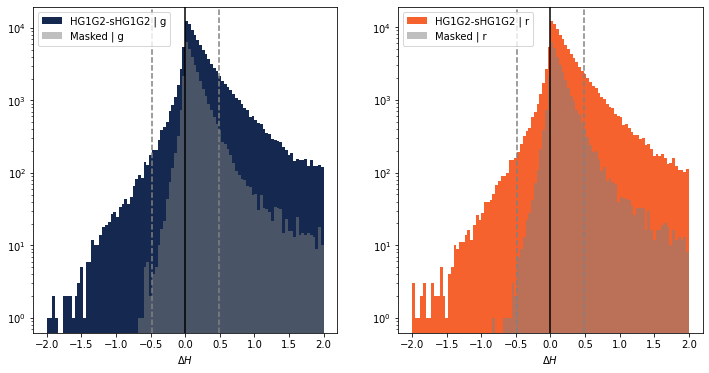

In [14]:
# HG vs HG1G2hyb
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG1G2_H_{f}'] - data[f'HG1G2hyb_H_{f}']

    hn, hb, _ = ax[i].hist( x, range=r, bins=b, label=f'HG1G2-sHG1G2 | {f}', color=fink_colors[i] )
    statarr.append([hb[ np.argmax(hn) ], np.std(x)])

    ax[i].hist( x[maskG1G2&maskG1G2hyb], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5 )

    ax[i].axvline( statarr[i][0], color='black' )
    ax[i].axvline( statarr[i][0]-statarr[i][1], color='gray', linestyle='dashed' )
    ax[i].axvline( statarr[i][0]+statarr[i][1], color='gray', linestyle='dashed' )
    
for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')
    
fig.savefig(f'{data_fink}/gfx_models/deltaH_HG1G2_sHG1G2.png', facecolor='white')

- HG seems to fail as expected
- HG1G2 vs spin non symmetric: effect of oppositions
- Hspin often smaller

Apparently a systematic larger value of H (HG) wrt H (hybrid)

H_s = m - f - g - s
    = H - s

so
H_S - H = - s
 s s always negative -> H_S - H > 0
  
unless the issues with geometry are modifying g, so everything is messed up in non-hybrid model!
  

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

1 HG_H_r HG1G2_H_r
2 HG_H_r HG1G2hyb_H_r
3 HG1G2_H_r HG1G2hyb_H_r


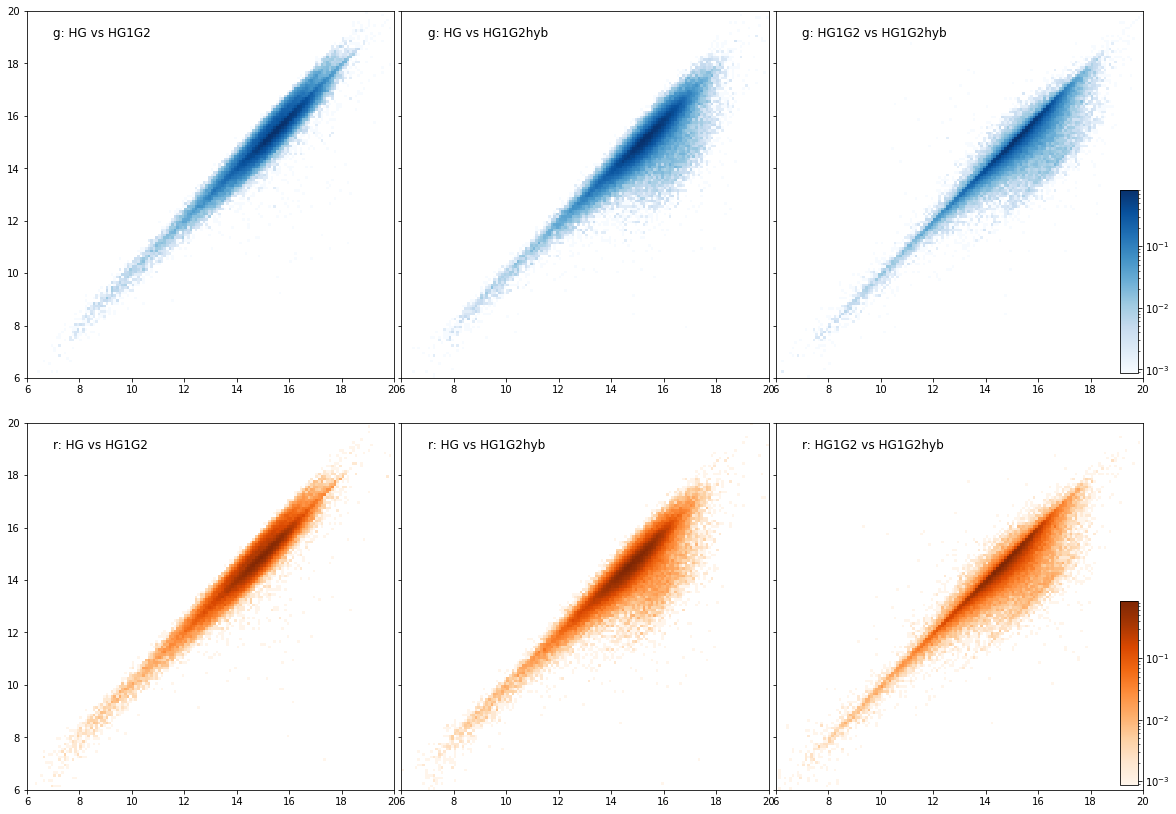

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(20,15), gridspec_kw={'hspace':0.02, 'wspace':0.02})

hh_r = [ [0,22], [0,22] ]
bb_r = np.array([1,1]) * 88
xlab, ylab = 2,20

hh_r = [ [6,20], [6,20] ]
bb_r = np.array([1,1]) * (hh_r[0][1] - hh_r[0][0])*10
xlab, ylab = 7,19

models = ['HG','HG1G2','HG1G2hyb']
for i in range(3):
    for j in range(i+1,3):

        mx = models[i]
        my = models[j]
        loc_f = 'r'
        print( i+j, f'{mx}_H_{loc_f}', f'{my}_H_{loc_f}' )
        
        # Filter g
        x = data[f'{mx}_H_g']
        y = data[f'{my}_H_g']
        loc_cmap = 'Blues' 
        _ , _, _, img = ax[0,i+j-1].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm='log', density=True )
        ax[0,i+j-1].text( xlab, ylab, f'g: {mx} vs {my}', fontsize='large' )
        
        # Filter r
        x = data[f'{mx}_H_r']
        y = data[f'{my}_H_r']
        loc_cmap = 'Oranges' 
        _ , _, _, imr = ax[1,i+j-1].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm='log', density=True )
        ax[1,i+j-1].text( xlab, ylab, f'r: {mx} vs {my}', fontsize='large' )

        ax[0,i+j-1].set_aspect('equal')
        ax[1,i+j-1].set_aspect('equal')
        
        if (i+j-1)>0:
            ax[0,i+j-1].set_yticklabels('')
            ax[1,i+j-1].set_yticklabels('')
    
axinsg = inset_axes(
    ax[0,2],
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="lower right",
)
fig.colorbar(img, cax=axinsg)


axinsr = inset_axes(
    ax[1,2],
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="lower right",
)
fig.colorbar(imr, cax=axinsr)

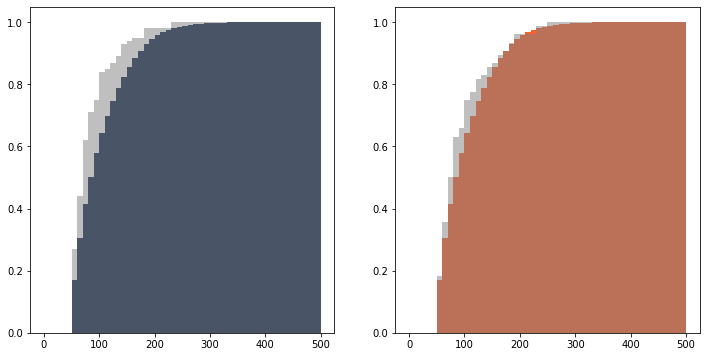

In [17]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [0,500]
b = 50

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']
    cond = np.abs(x) > 2
    
    ax[i].hist( data['n_obs'], range=r, bins=b, label=f'HG-HG1G2 | {f}', color=fink_colors[i], density=True, cumulative=True )
    ax[i].hist( data.loc[cond, 'n_obs'], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5, density=True, cumulative=True )


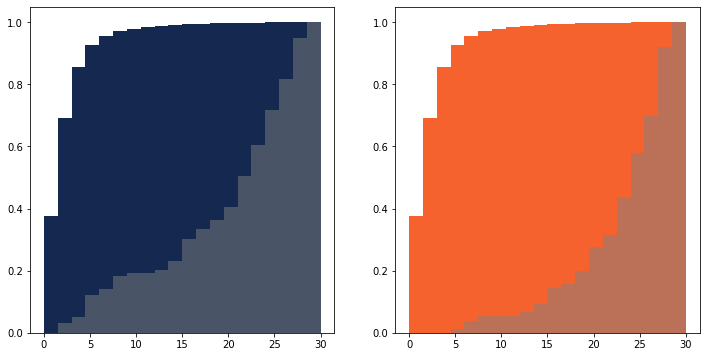

In [34]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [0,30]
b = 20

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']
    cond = np.abs(x) > 2
    
    ax[i].hist( data['minphase'], range=r, bins=b, label=f'HG-HG1G2 | {f}', color=fink_colors[i], density=True, cumulative=True )
    ax[i].hist( data.loc[cond, 'minphase'], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5, density=True, cumulative=True )
    


Text(0, 0.5, '$\\Delta H$ = HG - HG1G2')

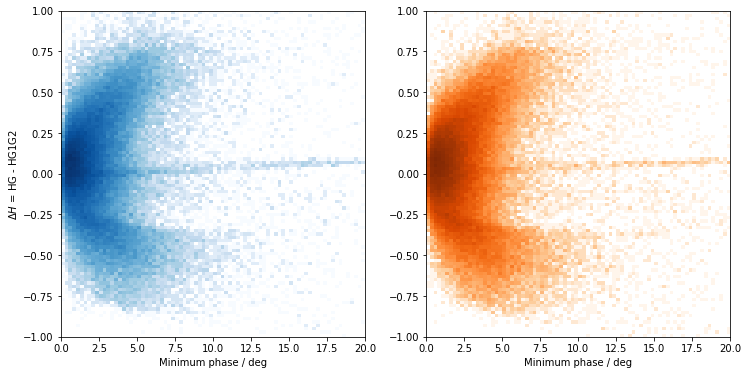

In [19]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

hh_r = [ [0,20], [-1,1] ]
bb_r = [80,100]
xlab, ylab = 2,20


statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'minphase']
    y = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']

    if f=='g':
        loc_cmap = 'Blues' 
    else:
        loc_cmap = 'Oranges' 
    ax[i].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm='log', density=True )

    ax[i].set_xlabel('Minimum phase / deg')
    
ax[0].set_ylabel('$\Delta H$ = HG - HG1G2')

Text(0, 0.5, '$\\Delta H$ = HG - HG1G2hyb')

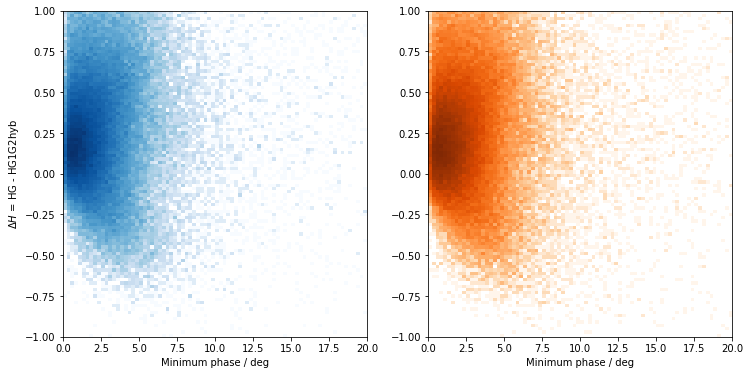

In [20]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

hh_r = [ [0,20], [-1,1] ]
bb_r = [80,100]
xlab, ylab = 2,20


statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'minphase']
    y = data[f'HG_H_{f}'] - data[f'HG1G2hyb_H_{f}']

    if f=='g':
        loc_cmap = 'Blues' 
    else:
        loc_cmap = 'Oranges' 
    ax[i].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm='log', density=True )

    ax[i].set_xlabel('Minimum phase / deg')
    
ax[0].set_ylabel('$\Delta H$ = HG - HG1G2hyb')

Text(0, 0.5, '$\\Delta H$ = HG1G2 - HG1G2hyb')

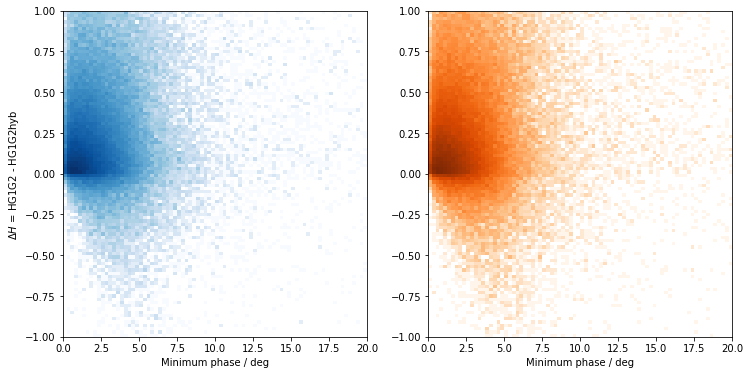

In [21]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

hh_r = [ [0,20], [-1,1] ]
bb_r = [80,100]
xlab, ylab = 2,20


statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'minphase']
    y = data[f'HG1G2_H_{f}'] - data[f'HG1G2hyb_H_{f}']

    if f=='g':
        loc_cmap = 'Blues' 
    else:
        loc_cmap = 'Oranges' 
    ax[i].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm='log', density=True )

    ax[i].set_xlabel('Minimum phase / deg')
    
ax[0].set_ylabel('$\Delta H$ = HG1G2 - HG1G2hyb')

## Colors

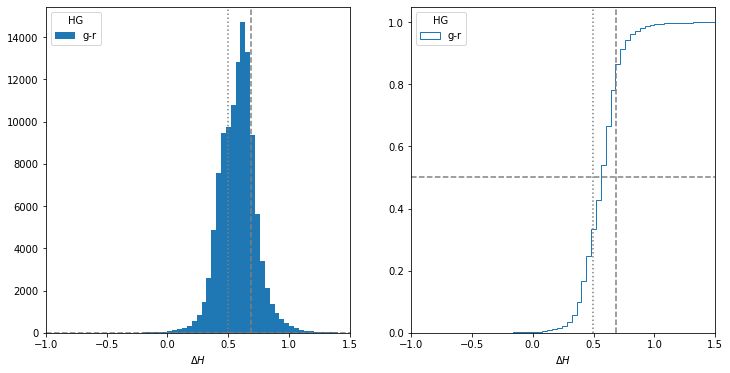

In [22]:
# HG colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

x = data.HG_H_g - data.HG_H_r
ax[0].hist( x, range=r, bins=b, label='g-r' )
ax[1].hist( x, range=r, bins=b, density=True, cumulative=True, histtype='step', label='g-r' )

for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left', title='HG')
    a.set_xlim( -1, 1.5 )
    a.axhline(0.5, color='gray', linestyle='--')
    a.axvline( -(S_color['g']-S_color['r']), color='gray', linestyle='dashed', label='S types')
    a.axvline( -(sun_color['g']-sun_color['r']), color='gray', linestyle='dotted', label='C types')

# ax[0].set_yscale('log')

fig.savefig(f'{data_fink}/gfx_models/color_HG.png', facecolor='white')

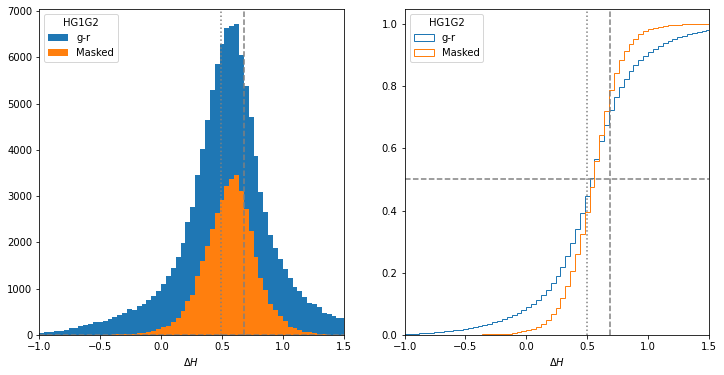

In [23]:
# HG1G2 colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

x = data.HG1G2_H_g - data.HG1G2_H_r
loc_mask = maskG1G2
ax[0].hist( x, range=r, bins=b, label='g-r' )
ax[0].hist( x[loc_mask], range=r, bins=b, label='Masked' )

ax[1].hist( x, range=r, bins=b, density=True, cumulative=True, histtype='step', label='g-r' )
ax[1].hist( x[loc_mask], range=r, bins=b, density=True, cumulative=True, histtype='step', label='Masked' )


for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left', title='HG1G2')
    a.set_xlim( -1, 1.5 )
    a.axhline(0.5, color='gray', linestyle='--')
    a.axvline( -(S_color['g']-S_color['r']), color='gray', linestyle='dashed', label='S types')
    a.axvline( -(sun_color['g']-sun_color['r']), color='gray', linestyle='dotted', label='C types')

# ax[0].set_yscale('log')

fig.savefig(f'{data_fink}/gfx_models/color_HG1G2.png', facecolor='white')

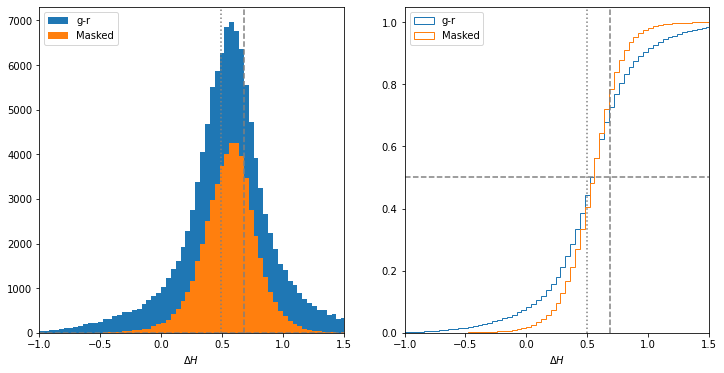

In [24]:
# Hybrid colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

x = data.HG1G2hyb_H_g - data.HG1G2hyb_H_r
loc_mask = maskG1G2hyb & (data.minphase<2.5) # Test minphase influence
loc_mask = maskG1G2hyb 

ax[0].hist( x, range=r, bins=b, label='g-r' )
ax[0].hist( x[loc_mask], range=r, bins=b, label='Masked' )

ax[1].hist( x, range=r, bins=b, density=True, cumulative=True, histtype='step', label='g-r' )
ax[1].hist( x[loc_mask], range=r, bins=b, density=True, cumulative=True, histtype='step', label='Masked' )


for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_xlim( -1, 1.5 )
    a.axhline(0.5, color='gray', linestyle='--')
    a.axvline( -(S_color['g']-S_color['r']), color='gray', linestyle='dashed', label='S types')
    a.axvline( -(sun_color['g']-sun_color['r']), color='gray', linestyle='dotted', label='C types')

# ax[0].set_yscale('log')

fig.savefig(f'{data_fink}/gfx_models/color_sHG1G2.png', facecolor='white')

N with colors:  18185


U    105555
S      8188
C      1404
Name: ztf_complex, dtype: int64

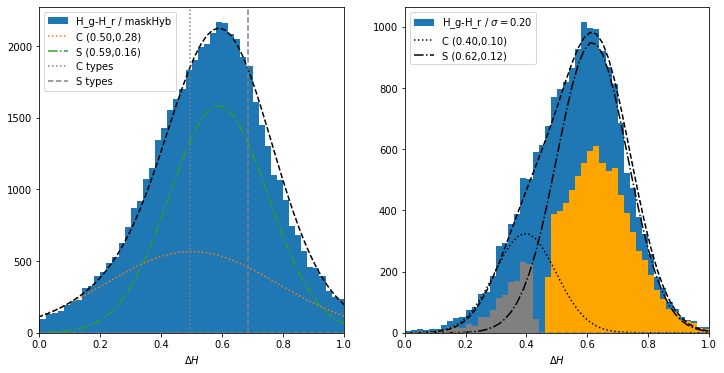

In [25]:
# Hybrid colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-0.5,1.5]
b = 100

cond = maskG1G2hyb
dH = data.loc[cond,'HG1G2hyb_H_g'] - data.loc[cond,'HG1G2hyb_H_r']
bin_values, bin_boundaries, _ = ax[0].hist( dH, range=r, bins=b, label='H_g-H_r / maskHyb' )


# bin_values, bin_boundaries = np.histogram(dH, bins=b)
x = bin_boundaries[:-1] + 0.5*(bin_boundaries[1] - bin_boundaries[0])
popt, pcov = curve_fit(
    double_gauss, 
    x, 
    bin_values, 
    p0=[1000, color_C, 0.1, 1000, color_S, 0.1], 
    bounds=([0, 0, 0, 0.5, 0, 0], [1e5, 0.5, 1.5, 1e5, 1.0, 1.5])
)
ax[0].plot(x, gauss(x, *popt[:3]), label='C ({:.2f},{:.2f})'.format(popt[1],popt[2]), ls='dotted')
ax[0].plot(x, gauss(x, *popt[3:]), label='S ({:.2f},{:.2f})'.format(popt[4],popt[5]), ls='dashdot')
ax[0].plot(x, double_gauss(bin_boundaries[:-1], *popt), ls='--', color='black')

ax[0].axvline( color_C, color='gray', linestyle='dotted', label='C types')
ax[0].axvline( color_S, color='gray', linestyle='dashed', label='S types')


unc_H = 0.2
cond = maskG1G2hyb * \
       (data['HG1G2hyb_dH_g']<unc_H) * \
       (data['HG1G2hyb_dH_r']<unc_H)
dH = data.loc[cond,'HG1G2hyb_H_g'] - data.loc[cond,'HG1G2hyb_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, label=f'H_g-H_r / $\sigma={unc_H:.2f}$' )
print('N with colors: ', len(data[cond]) )

# bin_values, bin_boundaries = np.histogram(dH, bins=b)
x = bin_boundaries[:-1] + 0.5*(bin_boundaries[1] - bin_boundaries[0])
popt, pcov = curve_fit(
    double_gauss, 
    x, 
    bin_values, 
    p0=[1000, color_C, 0.1, 1000, color_S, 0.1], 
    bounds=([0, 0, 0, 0.5, 0, 0], [1e5, 0.5, 1.5, 1e5, 1.0, 1.5])
)
ax[1].plot(x, gauss(x, *popt[:3]), label='C ({:.2f},{:.2f})'.format(popt[1],popt[2]), color='k', ls='dotted')
ax[1].plot(x, gauss(x, *popt[3:]), label='S ({:.2f},{:.2f})'.format(popt[4],popt[5]), color='k', ls='dashdot')
ax[1].plot(x, double_gauss(bin_boundaries[:-1], *popt), ls='--', color='black')

# ax[1].axvline( color_C, color='gray', linestyle='dotted', label='C types')
# ax[1].axvline( color_S, color='gray', linestyle='dashed', label='S types')



# ----
sqrt2 = np.sqrt(2.0)
A1 = popt[0]
mu1 = popt[1]
std1 = popt[2]

A2 = popt[3]
mu2 = popt[4]
std2 = popt[5]


x1 = (data['HG1G2hyb_H_g'] - data['HG1G2hyb_H_r']) - (data['HG1G2hyb_dH_g'] - data['HG1G2hyb_dH_r'])
x2 = (data['HG1G2hyb_H_g'] - data['HG1G2hyb_H_r']) + (data['HG1G2hyb_dH_g'] - data['HG1G2hyb_dH_r'])

pC = (A1*special.erf((x2 - mu1) / (sqrt2 * std1)) - 
          A1*special.erf((x1 - mu1) / (sqrt2 * std1)))
pS = (A2*special.erf((x2 - mu2) / (sqrt2 * std2)) - 
          A2*special.erf((x1 - mu2) / (sqrt2 * std2)))

# Add Class to DataFrame
data['ztf_pC'] = 0.0
data['ztf_pS'] = 0.0
data['ztf_complex'] = 'U'

cond_z = (pC + pS) > 0
data.loc[cond_z, 'ztf_pC'] = pC[cond_z] / (pC[cond_z] + pS[cond_z])
data.loc[cond_z, 'ztf_pS'] = pS[cond_z] / (pC[cond_z] + pS[cond_z])

rate = 0.2
condS = data['ztf_pS'] - data['ztf_pC'] > rate
data.loc[condS, 'ztf_complex'] = 'S'
data.loc[condS, 'ztf_pcomplex'] = data.loc[cond, 'ztf_pS']
condC = data['ztf_pC'] - data['ztf_pS'] > rate
data.loc[condC, 'ztf_complex'] = 'C'

#cleaning

data.loc[~cond,'ztf_complex'] = 'U'

cond = maskG1G2hyb * \
       (data['HG1G2hyb_dH_g']<unc_H) * \
       (data['HG1G2hyb_dH_r']<unc_H) * \
       (data['ztf_complex']=='C')
dH = data.loc[cond,'HG1G2hyb_H_g'] - data.loc[cond,'HG1G2hyb_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, color='gray' )

cond = maskG1G2hyb * \
       (data['HG1G2hyb_dH_g']<unc_H) * \
       (data['HG1G2hyb_dH_r']<unc_H) * \
       (data['ztf_complex']=='S')
dH = data.loc[cond,'HG1G2hyb_H_g'] - data.loc[cond,'HG1G2hyb_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, color='orange' )


for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.axhline(0.5, color='gray', linestyle='--')
    a.set_xlim(0,1)

fig.savefig(f'{data_fink}/gfx_models/deltaH_g_r.png', facecolor='white')

data['ztf_complex'].value_counts()


Text(0.5, 0, 'Eccentricity')

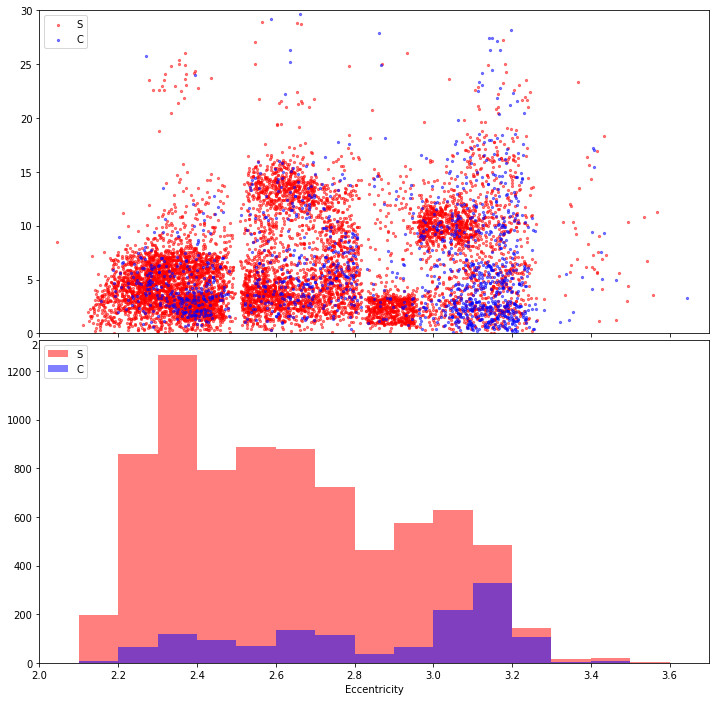

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(12,12), gridspec_kw={'hspace':0.02})

s = 20
alpha = 0.5
alp = 0.5
C = (data['ztf_complex'] == 'C')
S = (data['ztf_complex'] == 'S')

# a i
ax[0].scatter( data.loc[S,'orbital_elements.semi_major_axis.value'], 
               data.loc[S,'orbital_elements.inclination.value'], color='red', label='S', marker='.', s=s, alpha=alpha)
ax[0].scatter( data.loc[C,'orbital_elements.semi_major_axis.value'], 
               data.loc[C,'orbital_elements.inclination.value'], color='blue', label='C', marker='.', s=s, alpha=alpha)

# hist a
r = [2,3.7]
b = 17
ax[1].hist( data.loc[S,'orbital_elements.semi_major_axis.value'], range=r, bins=b, color='red', label='S', alpha=alp )
ax[1].hist( data.loc[C,'orbital_elements.semi_major_axis.value'], range=r, bins=b, color='blue', label='C', alpha=alp )

# a e
# ax[1].scatter( data.loc[S,'orbital_elements.semi_major_axis.value'], 
#                data.loc[S,'orbital_elements.eccentricity.value'], color='red', label='S', marker='.', s=s, alpha=alpha)
# ax[1].scatter( data.loc[C,'orbital_elements.semi_major_axis.value'], 
#                data.loc[C,'orbital_elements.eccentricity.value'], color='blue', label='C', marker='.', s=s, alpha=alpha)

for a in ax:
    a.set_xlim(r)
    a.legend(loc='upper left')

ax[0].set_ylim(0,30)
# ax[1].set_ylim(0,0.6)
ax[0].set_xlabel('Semi-major axis / au')
ax[0].set_xlabel('Inclination / deg')
ax[1].set_xlabel('Eccentricity')

# G1G2 distribution

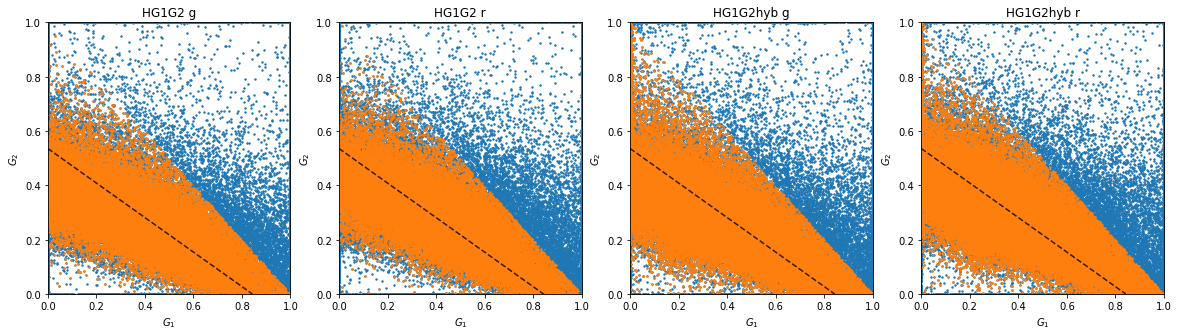

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))

r = [-2,2]
b = 100


x = data.HG1G2_G1_g
y = data.HG1G2_G2_g
ax[0].scatter( x, y, s=2 )
ax[0].scatter( x[maskG1G2], y[maskG1G2], s=2 )
ax[0].set_title('HG1G2 g', ha='center', fontsize='large') 

x = data.HG1G2_G1_r
y = data.HG1G2_G2_r
ax[1].scatter( x, y, s=2 )
ax[1].scatter( x[maskG1G2], y[maskG1G2], s=2 )
ax[1].set_title('HG1G2 r', ha='center', fontsize='large') 

x = data.HG1G2hyb_G1_g
y = data.HG1G2hyb_G2_g
ax[2].scatter( x, y, s=2 )
ax[2].scatter( x[maskG1G2hyb], y[maskG1G2hyb], s=2 )
ax[2].set_title('HG1G2hyb g', ha='center', fontsize='large') 

x = data.HG1G2hyb_G1_r
y = data.HG1G2hyb_G2_r
ax[3].scatter( x, y, s=2 )
ax[3].scatter( x[maskG1G2hyb], y[maskG1G2hyb], s=2 )
ax[3].set_title('HG1G2hyb r', ha='center', fontsize='large') 


for a in ax:
    a.set_xlabel('$G_1$')
    a.set_ylabel('$G_2$')
    a.set_xlim(0,1)
    a.set_ylim(0,1)
    
    # G12 line
    xx = np.linspace(0,1,num=5)    
    G1, G2 = G12_to_G1G2(xx)
    a.plot(G1, G2, linestyle="--", color="black", alpha=0.8)

# fig.savefig(f'{data_fink}/gfx_models/G1G2_models.png', facecolor='white')

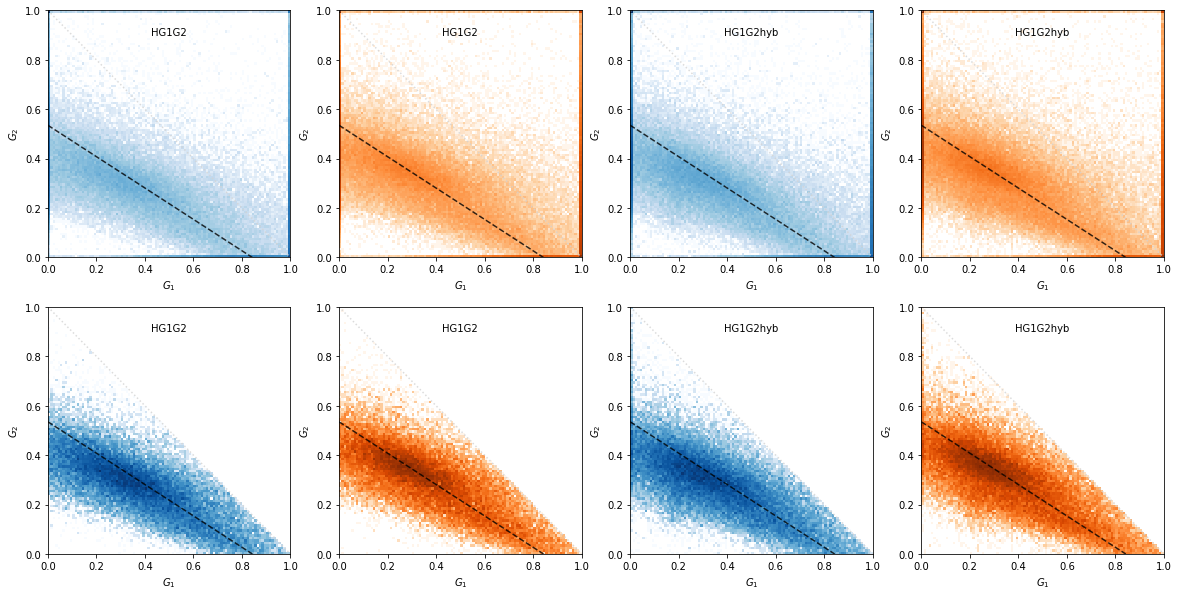

In [28]:
fig, ax = plt.subplots(2, 4, figsize=(20,10))

r = [0,1]
b = 100


x = data.HG1G2_G1_g
y = data.HG1G2_G2_g
ax[0,0].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues' )
ax[1,0].hist2d( x[maskG1G2], y[maskG1G2], range=[r,r], bins=b, norm='log', cmap='Blues' )

x = data.HG1G2_G1_r
y = data.HG1G2_G2_r
ax[0,1].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges' )
ax[1,1].hist2d( x[maskG1G2], y[maskG1G2], range=[r,r], bins=b, norm='log', cmap='Oranges' )

x = data.HG1G2hyb_G1_g
y = data.HG1G2hyb_G2_g
ax[0,2].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues' )
ax[1,2].hist2d( x[maskG1G2hyb], y[maskG1G2hyb], range=[r,r], bins=b, norm='log', cmap='Blues' )

x = data.HG1G2hyb_G1_r
y = data.HG1G2hyb_G2_r
ax[0,3].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges' )
ax[1,3].hist2d( x[maskG1G2hyb], y[maskG1G2hyb], range=[r,r], bins=b, norm='log', cmap='Oranges' )


for a in ax.ravel():
    a.set_xlabel('$G_1$')
    a.set_ylabel('$G_2$')
    a.set_xlim(0,1)
    a.set_ylim(0,1)
    
    # G12 line
    xx = np.linspace(0,1,num=5)    
    G1, G2 = G12_to_G1G2(xx)
    a.plot(G1, G2, linestyle="--", color="black", alpha=0.8)
    a.plot(xx, 1-xx, linestyle="dotted", color="lightgrey", alpha=0.8)

for a in ax[:,0:2].ravel():
    a.text(0.5,0.9, 'HG1G2', ha='center' )

for a in ax[:,2:].ravel():
    a.text(0.5,0.9, 'HG1G2hyb', ha='center' )
    
# fig.savefig(f'{data_fink}/gfx_models/G1G2_models.png', facecolor='white')

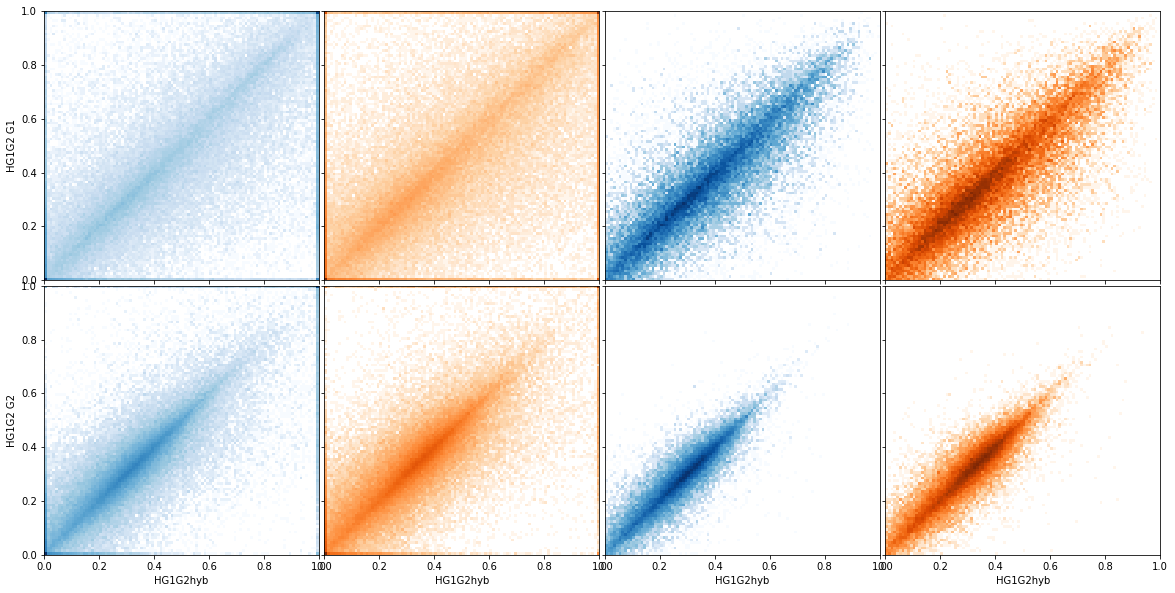

In [35]:
# Overall comparison of G1 G2
fig, ax = plt.subplots(2, 4, figsize=(20,10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

# ax = axs.ravel() 
r = [0,1]
b = 100

mm = maskG1G2 & maskG1G2hyb


ax[0,0].hist2d( data.HG1G2_G1_g, data.HG1G2hyb_G1_g, density=True, range=[r,r], bins=b, cmap='Blues', norm='log' )
ax[0,1].hist2d( data.HG1G2_G1_r, data.HG1G2hyb_G1_r, density=True, range=[r,r], bins=b, cmap='Oranges', norm='log' )
ax[0,2].hist2d( data.HG1G2_G1_g[mm], data.HG1G2hyb_G1_g[mm], density=True, range=[r,r], bins=b, cmap='Blues', norm='log' )
ax[0,3].hist2d( data.HG1G2_G1_r[mm], data.HG1G2hyb_G1_r[mm], density=True, range=[r,r], bins=b, cmap='Oranges', norm='log' )

ax[1,0].hist2d( data.HG1G2_G2_g, data.HG1G2hyb_G2_g, density=True, range=[r,r], bins=b, cmap='Blues', norm='log' )
ax[1,1].hist2d( data.HG1G2_G2_r, data.HG1G2hyb_G2_r, density=True, range=[r,r], bins=b, cmap='Oranges', norm='log' )
ax[1,2].hist2d( data.HG1G2_G2_g[mm], data.HG1G2hyb_G2_g[mm], density=True, range=[r,r], bins=b, cmap='Blues', norm='log' )
ax[1,3].hist2d( data.HG1G2_G2_r[mm], data.HG1G2hyb_G2_r[mm], density=True, range=[r,r], bins=b, cmap='Oranges', norm='log' )

for a in ax[:,1:].ravel():
    a.set_yticklabels('')
for a in ax[0,:].ravel():
    a.set_xticklabels('')

ax[0,0].set_ylabel('HG1G2 G1')
ax[1,0].set_ylabel('HG1G2 G2')

for a in ax[1,:]:
    a.set_xlabel('HG1G2hyb')



## RMS and Chi-square

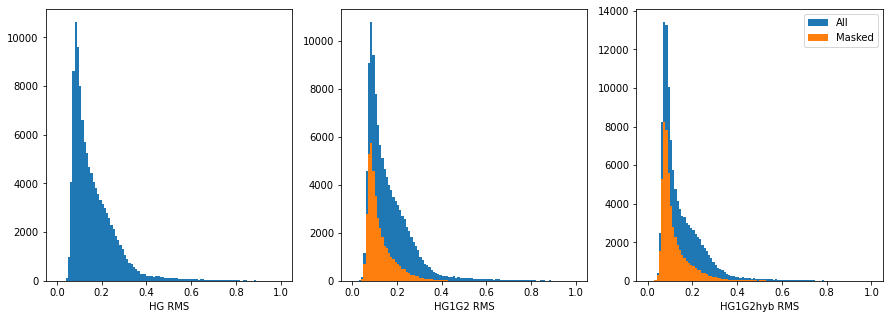

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

r = [0,1]
b = 100


for km, model in enumerate(['HG','HG1G2','HG1G2hyb']):
    
    ax[km].hist( data.loc[:,f'{model}_rms'], range=r, bins=b, label='All')

    if model=='HG1G2':
        ax[km].hist( data.loc[maskG1G2,f'{model}_rms'], range=r, bins=b, label='Masked')
    elif model=='HG1G2hyb':
        ax[km].hist( data.loc[maskG1G2hyb,f'{model}_rms'], range=r, bins=b, label='Masked')

    ax[km].set_xlabel(f'{model} RMS')

    
ax[2].legend(loc='upper right')
# fig.savefig(f'{data_fink}/gfx_models/rms_histo.png', facecolor='white')

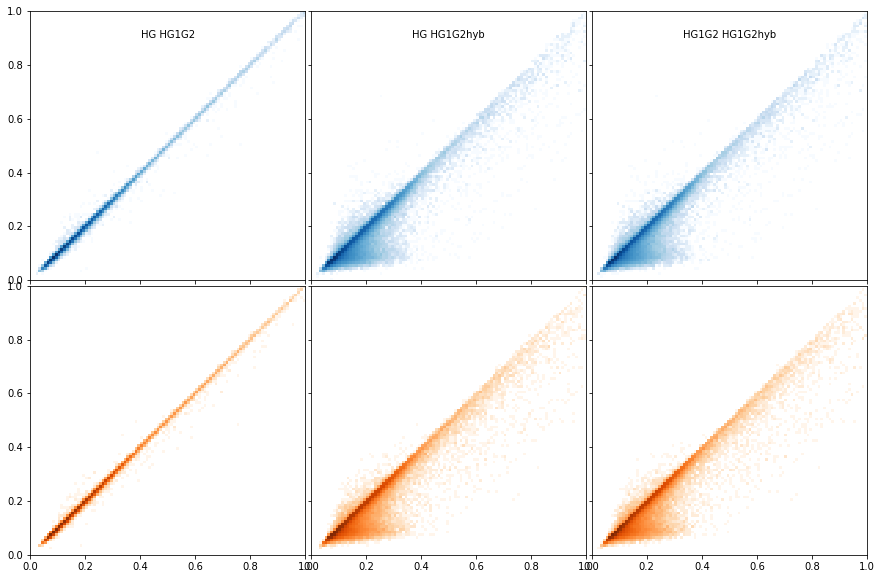

In [42]:
fig, ax = plt.subplots(2, 3, figsize=(15,10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [0,1]
b = 100

x = data['HG_rms_g']
y = data['HG1G2_rms_g']
ax[0,0].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues')

x = data['HG_rms_r']
y = data['HG1G2_rms_r']
ax[1,0].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges')




x = data['HG_rms_g']
y = data['HG1G2hyb_rms_g']
ax[0,1].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues')

x = data['HG_rms_r']
y = data['HG1G2hyb_rms_r']
ax[1,1].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges')




x = data['HG1G2_rms_g']
y = data['HG1G2hyb_rms_g']
ax[0,2].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues')

x = data['HG1G2_rms_r']
y = data['HG1G2hyb_rms_r']
ax[1,2].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges')


ax[0,0].text( 0.5, 0.9, 'HG HG1G2', ha='center')
ax[0,1].text( 0.5, 0.9, 'HG HG1G2hyb', ha='center')
ax[0,2].text( 0.5, 0.9, 'HG1G2 HG1G2hyb', ha='center')


for a in ax[:,1:].ravel():
    a.set_yticklabels('')
for a in ax[0,:].ravel():
    a.set_xticklabels('')

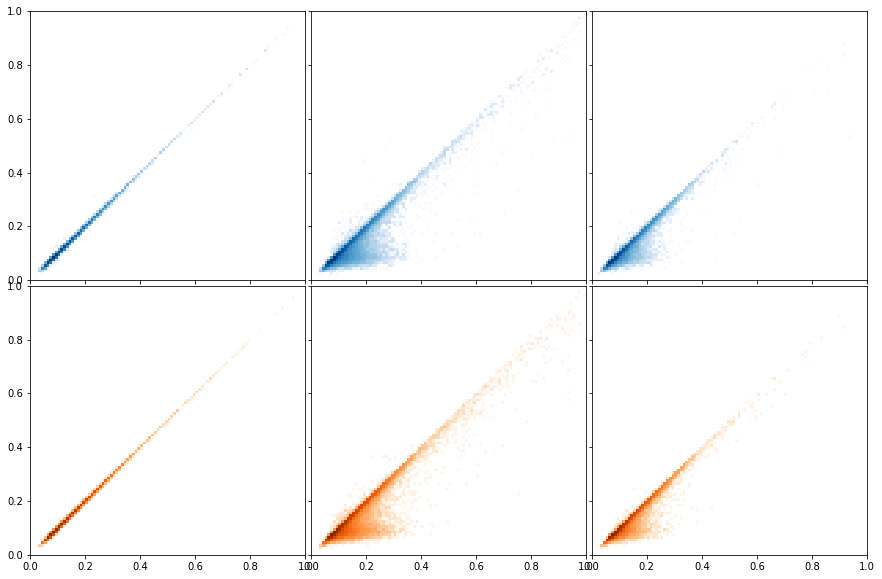

In [38]:
fig, ax = plt.subplots(2, 3, figsize=(15,10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [0,1]
b = 100

x = data.loc[maskG1G2,'HG_rms_g']
y = data.loc[maskG1G2,'HG1G2_rms_g']
ax[0,0].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues')

x = data.loc[maskG1G2,'HG_rms_r']
y = data.loc[maskG1G2,'HG1G2_rms_r']
ax[1,0].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges')


x = data.loc[maskG1G2hyb,'HG_rms_g']
y = data.loc[maskG1G2hyb,'HG1G2hyb_rms_g']
ax[0,1].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues')

x = data.loc[maskG1G2hyb,'HG_rms_r']
y = data.loc[maskG1G2hyb,'HG1G2hyb_rms_r']
ax[1,1].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges')


mm = maskG1G2 & maskG1G2hyb
x = data.loc[mm,'HG1G2_rms_g']
y = data.loc[mm,'HG1G2hyb_rms_g']
ax[0,2].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Blues')

x = data.loc[mm,'HG1G2_rms_r']
y = data.loc[mm,'HG1G2hyb_rms_r']
ax[1,2].hist2d( x, y, range=[r,r], bins=b, norm='log', cmap='Oranges')

for a in ax[:,1:].ravel():
    a.set_yticklabels('')
for a in ax[0,:].ravel():
    a.set_xticklabels('')

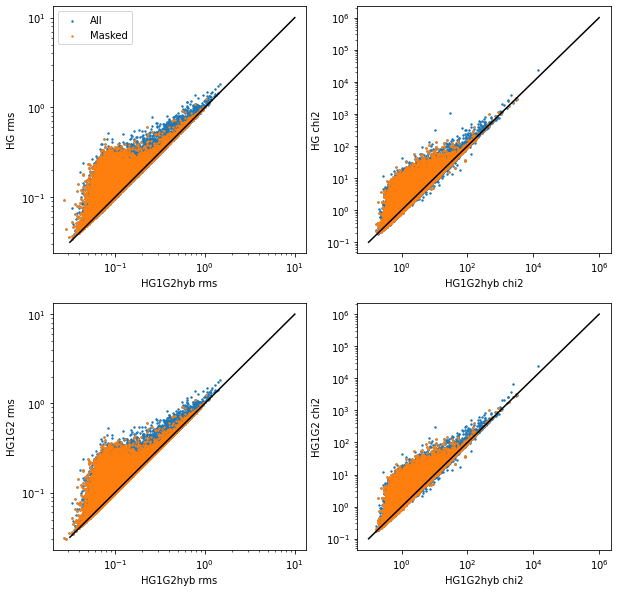

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

ref = 'HG1G2hyb'

cond = mask # All ok
cond = maskG1G2hyb # Hybrid ok


for km, model in enumerate(['HG','HG1G2']):
    
    # print(km, model)
    axs[km,0].scatter( data.loc[:,f'{ref}_rms'], data.loc[:,f'{model}_rms'], s=2, label='All' )
    axs[km,0].scatter( data.loc[cond,f'{ref}_rms'], data.loc[cond,f'{model}_rms'], s=2, label='Masked' )
    axs[km,0].set_xlabel( f'{ref} rms' )
    axs[km,0].set_ylabel( f'{model} rms' )        
        
    axs[km,1].scatter( data.loc[:,f'{ref}_chi2red'], data.loc[:,f'{model}_chi2red'], s=2 )
    axs[km,1].scatter( data.loc[cond,f'{ref}_chi2red'], data.loc[cond,f'{model}_chi2red'], s=2 )
    axs[km,1].set_xlabel( f'{ref} chi2' )
    axs[km,1].set_ylabel( f'{model} chi2' )

x_rms = np.logspace(-1.5, 1, num=100 )
x_chi = np.logspace(-1, 6, num=100 )

for a in axs[:,0]:
    a.plot(x_rms, x_rms, color='black')
    
for a in axs[:,1]:
    a.plot(x_chi, x_chi, color='black')

for a in axs.ravel():
    a.set_xscale('log')
    a.set_yscale('log')
    
axs[0,0].legend(loc='upper left')

# fig.savefig(f'{data_fink}/gfx_models/rms_models.png', facecolor='white')

KeyError: 'HG1G2sp_chi2red'

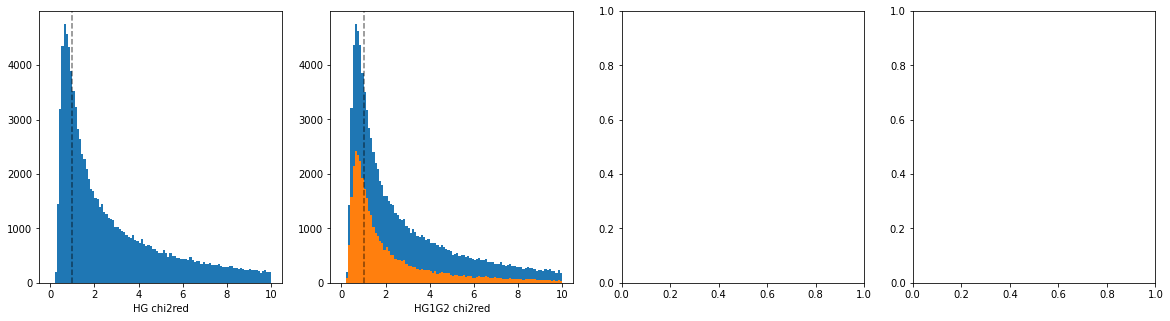

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

r = [0,10]
b = 100


for km, model in enumerate(['HG','HG1G2','HG1G2sp','HG1G2hyb']):
    
    ax[km].hist( data.loc[:,f'{model}_chi2red'], range=r, bins=b, label='All')

    if model=='HG1G2':
        ax[km].hist( data.loc[maskG1G2,f'{model}_chi2red'], range=r, bins=b, label='Masked')
    elif model=='HG1G2sp':
        ax[km].hist( data.loc[maskG1G2sp,f'{model}_chi2red'], range=r, bins=b, label='Masked')
    elif model=='HG1G2hyb':
        ax[km].hist( data.loc[maskG1G2hyb,f'{model}_chi2red'], range=r, bins=b, label='Masked')

    ax[km].axvline(1,linestyle='dashed', color='black', alpha=0.5 )
    ax[km].set_xlabel(f'{model} chi2red')

    
ax[3].legend(loc='upper right')
fig.savefig(f'{data_fink}/gfx_models/chi2_histo.png', facecolor='white')

# Spins

In [ ]:
data.columns

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

r = [-360,360]
b = 360
ax[0].hist( data.loc[:,'HG1G2sp_RA0']-data.loc[:,'HG1G2hyb_RA0'], range=r, bins=b, label='All')
ax[0].hist( data.loc[mask,'HG1G2sp_RA0']-data.loc[mask,'HG1G2hyb_RA0'], range=r, bins=b, label='Masked')

r = [-180,180]
b = 180
ax[1].hist( data.loc[:,'HG1G2sp_DEC0']-data.loc[:,'HG1G2hyb_DEC0'], range=r, bins=b, label='All')
ax[1].hist( data.loc[mask,'HG1G2sp_DEC0']-data.loc[mask,'HG1G2hyb_DEC0'], range=r, bins=b, label='Masked')

r = [-1,1]
b = 40
ax[2].hist( data.loc[:,'HG1G2sp_R']-data.loc[:,'HG1G2hyb_R'], range=r, bins=b, label='All')
ax[2].hist( data.loc[mask,'HG1G2sp_R']-data.loc[mask,'HG1G2hyb_R'], range=r, bins=b, label='Masked')


ax[0].set_xlabel(f'$\Delta$ RA0')
ax[1].set_xlabel(f'$\Delta$ DEC0')
ax[2].set_xlabel(f'$\Delta$ R')

for a in ax:
    a.set_yscale('log')
# ax[3].legend(loc='upper right')

Parameters are absolutely not stable between sp and hybrid. Why?

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

r = [0,360]
b = 360
ax[0].hist( np.abs(data.loc[:,'HG1G2sp_RA0']-data.loc[:,'HG1G2hyb_RA0']), range=r, bins=b, label='All')
ax[0].hist( np.abs(data.loc[mask,'HG1G2sp_RA0']-data.loc[mask,'HG1G2hyb_RA0']), range=r, bins=b, label='Masked')
ax0 = ax[0].twinx()
ax0.hist( np.abs(data.loc[mask,'HG1G2sp_RA0']-data.loc[mask,'HG1G2hyb_RA0']), range=r, bins=b, density=True, cumulative=True, histtype='step', color='black')

r = [0,180]
b = 180
ax[1].hist( np.abs(data.loc[:,'HG1G2sp_DEC0']-data.loc[:,'HG1G2hyb_DEC0']), range=r, bins=b, label='All')
ax[1].hist( np.abs(data.loc[mask,'HG1G2sp_DEC0']-data.loc[mask,'HG1G2hyb_DEC0']), range=r, bins=b, label='Masked')
ax1 = ax[1].twinx()
ax1.hist( np.abs(data.loc[mask,'HG1G2sp_DEC0']-data.loc[mask,'HG1G2hyb_DEC0']), range=r, bins=b, density=True, cumulative=True, histtype='step', color='black')

r = [0,1]
b = 40
ax[2].hist( np.abs(data.loc[:,'HG1G2sp_R']-data.loc[:,'HG1G2hyb_R']), range=r, bins=b, label='All')
ax[2].hist( np.abs(data.loc[mask,'HG1G2sp_R']-data.loc[mask,'HG1G2hyb_R']), range=r, bins=b, label='Masked')
ax2 = ax[2].twinx()
ax2.hist( np.abs(data.loc[mask,'HG1G2sp_R']-data.loc[mask,'HG1G2hyb_R']), range=r, bins=b, density=True, cumulative=True, histtype='step', color='black')


ax[0].set_xlabel(f'$| \Delta RA0 |$')
ax[1].set_xlabel(f'$| \Delta DEC0 |$')
ax[2].set_xlabel(f'$| \Delta R |$')

for a in ax:
    a.set_yscale('log')
for a in [ax0,ax1,ax2]:
    a.set_ylim(0,1)
    
    
# ax[3].legend(loc='upper right')

# Best and worst cases

In [ ]:
data['delta_rms'] = data['HG1G2hyb_rms'] - data['HG1G2_rms']


cols = data.columns
cols = ['ssnamenr', 'number', 'name', 'n_days', 'n_obs', 'HG1G2hyb_R',
       'HG1G2hyb_dR', 'HG1G2hyb_rms', 'HG1G2hyb_chi2red','delta_rms']
cond = mask # & (data.HG1G2hyb_R>0.20)
data.loc[cond,cols].sort_values(by='delta_rms').head(20)

In [ ]:
data.columns[0:80]